# Preprocessing

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from collections import Counter

In [29]:
# Percentage of missing values
def missing_values_table(df):
    # Percentage of missing values for each column
    missing_percent = df.isnull().mean() * 100
    
    # Filter out columns with no missing values
    missing_data = missing_percent[missing_percent > 0].sort_values(ascending=False)
    
    # Create a dataframe of the result
    result = pd.DataFrame({'Missing Values (%)': missing_data, 
                           'Total Missing': df.isnull().sum()[missing_data.index]})
    return result

# Data Info
def Data_Info(df):
    # Exploratory Data Analysis (EDA)
    pd.set_option('display.max_columns', None)
    print(df.head(), '\n')

    missing_data = missing_values_table(df)
    print(missing_data, '\n')

# Loading the dataset
df = pd.read_csv('Social_Network_Ads.csv')

Data_Info(df)

# Dropping unnecessary columns
# df.drop(['ID', 'Unnamed: 0'], axis=1, inplace=True)

    User ID  Gender  Age  EstimatedSalary  Purchased
0  15624510    Male   19            19000          0
1  15810944    Male   35            20000          0
2  15668575  Female   26            43000          0
3  15603246  Female   27            57000          0
4  15804002    Male   19            76000          0 

Empty DataFrame
Columns: [Missing Values (%), Total Missing]
Index: [] 



Train shape: (320, 5), Test shape: (80, 5) 



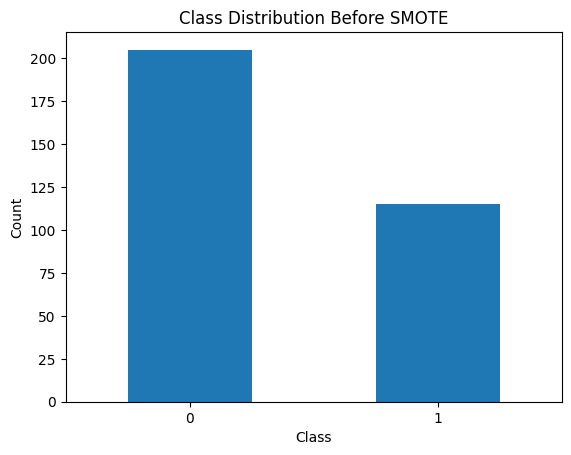

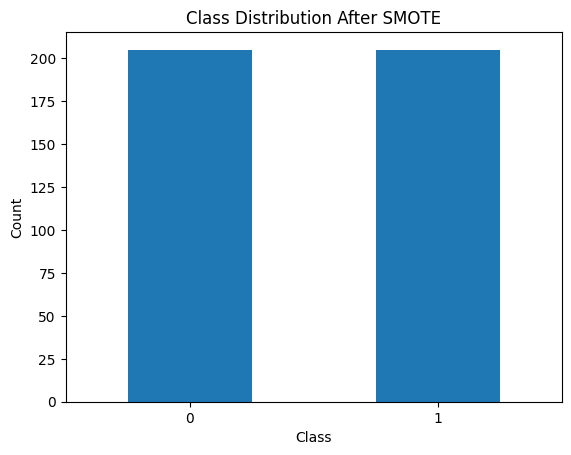

In [30]:
# Pipeline for processing dataset
def BigPipe(X, y):
    # Split numerical and categorical data
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    # Pipeline for numerical data
    numerical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()) # NOT needed in tree-based models (RandomForest, XGBoost)
    ])

    # Pipeline for categorical data
    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine both pipelines
    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

    # Apply pipeline on the dataset
    X_preprocessed = preprocessor.fit_transform(X)

    # Split the dataset to train set and test set
    X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}", '\n')

    return X_train, X_test, y_train, y_test


# Separate features and labels
X = df.drop('Purchased', axis=1)
y = df['Purchased']
X_train, X_test, y_train, y_test = BigPipe(X, y)

# Function for plotting class distribution
def plot_class_distribution(y, title):
    pd.Series(y).value_counts().plot(kind='bar', title=title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

# Apply SMOTE
def Apply_SMOTE(X_train, y_train):
    # Class distribution before applying SMOTE
    plot_class_distribution(y_train, 'Class Distribution Before SMOTE')

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # 'Class distribution after applying SMOTE
    plot_class_distribution(y_train, 'Class Distribution After SMOTE')

Apply_SMOTE(X_train, y_train)

# Evaluations

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def Evaluate_Regression(y_pred, y_test):
    mse = mean_squared_error(y_test, y_pred) * 100
    rmse = np.sqrt(mse) * 100
    mae = mean_absolute_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred) * 100

    return [("Mean Squared Error (%)", mse), ("Root Mean Squared Error (%)", rmse), 
            ("Mean Absolute Error (%)", mae), ("R-squared (%)", r2)]

def Evaluate_Classification(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='binary') * 100
    recall = recall_score(y_test, y_pred, average='binary') * 100
    f1 = f1_score(y_test, y_pred, average='binary') * 100

    return [("Accuracy (%)", accuracy), ("Precision (%)", precision), ("Recall (%)", recall), ("F1-Score (%)", f1)]

# Models

In [32]:
# Regression models
from sklearn.linear_model import LinearRegression # Linear
from sklearn.linear_model import Lasso # L1 Regularization
from sklearn.linear_model import Ridge # L2 Regularization
from sklearn.linear_model import ElasticNet # L1 + L2 Regularization
from sklearn.tree import DecisionTreeRegressor # Tree-based
from sklearn.ensemble import RandomForestRegressor # Tree-based
from xgboost import XGBRegressor # Gradient Boosting
from lightgbm import LGBMRegressor # Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor # Ensemble

regression_models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.1),
    "Ridge Regression": Ridge(alpha=1.0),
    "ElasticNet Regression": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Decision Tree Regressor": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost Regressor": XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    "LightGBM Regressor": LGBMRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100)
}

# Classification models
from sklearn.linear_model import LogisticRegression # Linear
from sklearn.tree import DecisionTreeClassifier # Tree-based
from sklearn.ensemble import RandomForestClassifier # Tree-based
from sklearn.neighbors import KNeighborsClassifier # Distance-Based
from sklearn.svm import SVC # Kernel-Based
from sklearn.ensemble import GradientBoostingClassifier # Ensemble
from xgboost import XGBClassifier # Gradient Boosting
from lightgbm import LGBMClassifier # Gradient Boosting
from sklearn.naive_bayes import GaussianNB # Probabilistic

classification_models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Support Vector Machine (SVM)": SVC(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=100),
    "XGBoost Classifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM Classifier": LGBMClassifier(),
    "Naive Bayes Classifier": GaussianNB()
}

# Fitting

In [33]:
# Run for regression models
def regression_fit():
    results = []
    for model_name, model in regression_models.items():
        model.fit(X_train, y_train) # Train model
        y_pred = model.predict(X_test) # Predict on the test set
        
        metrics = Evaluate_Regression(y_pred, y_test) # Evaluate the models
        
        # Create a dictionary for the results
        model_results = {"Model": model_name}
        model_results.update({metric_name: f"{metric_value:.2f}" for metric_name, metric_value in metrics})

        results.append(model_results)

    return results

# Run for classification models
def classification_fit():
    results = []
    for model_name, model in classification_models.items():
        model.fit(X_train, y_train) # Train model
        y_pred = model.predict(X_test) # Predict on the test set
        
        metrics = Evaluate_Classification(y_pred, y_test) # Evaluate the models
        
        # Create a dictionary for the results
        model_results = {"Model": model_name}
        model_results.update({metric_name: f"{metric_value:.2f}" for metric_name, metric_value in metrics})

        results.append(model_results)
    
    return results

# Export the results

In [34]:
import pandas as pd

# Fit models and return results
results = classification_fit()

# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Save to Excel
df_results.to_excel("results.xlsx", index=False, engine='openpyxl')

[LightGBM] [Info] Number of positive: 115, number of negative: 205
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.359375 -> initscore=-0.578078
[LightGBM] [Info] Start training from score -0.578078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

d:\NgJaBach\PseudoC\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:40:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
